## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.CNN import *

In [2]:
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(809)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)),
                          RandomResizedCrop((size,size),scale=(0.8,1),ratio=(0.9,1.1)),

## Prepare Dataset

In [5]:
size = 44
batch_size = 256
transformation = Compose([RandomHorizontalFlip(), 
                          Resize((size, size)), ToTensor()])

In [6]:
root = 'df_224/train'
train_data = create_dataset(root, transformation)
sampler = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler=sampler)

In [7]:
root = 'df_224/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [8]:
root = 'df_224/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[54921, 45909, 15063, 26486, 50205, 59206, 16911, 54962, 43174]


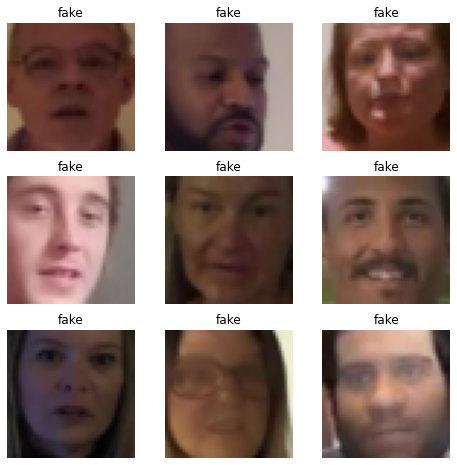

In [9]:
visualize_data(train_data)

[9344, 6180, 8797, 7681, 7168, 1029, 3642, 4368, 1148]


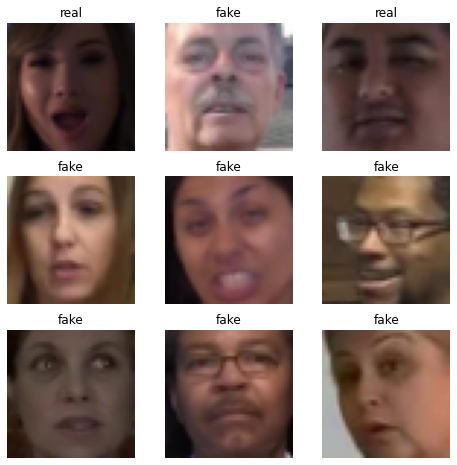

In [10]:
visualize_data(test_data)

## Initialize Model

In [11]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [12]:
from math import floor
# number of hidden layers and their sizes
hidden = [3, 256, 128, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 3

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [13]:
model = DeepSearch(hidden=hidden, kernel_size=kernel_size,
                   window=window, hidden_linear=hidden_linear).to(device)
#model.load_state_dict(torch.load("./DeepSearch2_15epochs")["model_state_dict"])
print(model)

DeepSearch(
  (conv_combined): Sequential(
    (0): DeepSearchConv(
      (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepSearchConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepSearchConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (avgpool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (linear_combined): Sequential(
    (0): DeepSearchLinear(
      (linear): Linear(in_features=9216, out_features=512, bias=True)
      (batch_norm): BatchNo

## Training Model

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [15]:
optimizer = create_adam_optimizer(model, lr=0.01)
#optimizer.load_state_dict(torch.load("./DeepSearch2_15epochs")["optimizer_state_dict"])

In [21]:
"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20, patience=5)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.5546875
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.560546875
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.5546875
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.56005859375
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.5651041666666666
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.5614483173076923
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.5604838709677419
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.5598958333333334
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.5621189024390244
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.5615658967391305
Epoch 1/20, Batch number: 50, Cumulated accuracy: 0.5628829656862745
Epoch 1/20, Batch number: 55, Cumulated accuracy: 0.5606863839285714
Epoch 1/20, Batch number: 60, Cumulated accuracy: 0.5604508196721312
Epoch 1/20, Batch number: 65, Cumulated accuracy: 0.5632694128787878
Epoch 1/20, Batch number: 70, Cumulated accuracy: 0.56437059859154

Epoch 2/20, Batch number: 290, Cumulated accuracy: 0.5948641537800687
Epoch 2/20, Batch number: 295, Cumulated accuracy: 0.5947793496621622
--- Epoch 2/20: Train loss: 0.6647, Train accuracy: 0.5949
--- Epoch 2/20: Val loss: 0.6621, Val accuracy: 0.6362
Epoch 3/20, Batch number: 0, Cumulated accuracy: 0.625
Epoch 3/20, Batch number: 5, Cumulated accuracy: 0.6178385416666666
Epoch 3/20, Batch number: 10, Cumulated accuracy: 0.6061789772727273
Epoch 3/20, Batch number: 15, Cumulated accuracy: 0.603515625
Epoch 3/20, Batch number: 20, Cumulated accuracy: 0.6000744047619048
Epoch 3/20, Batch number: 25, Cumulated accuracy: 0.5999098557692307
Epoch 3/20, Batch number: 30, Cumulated accuracy: 0.5984122983870968
Epoch 3/20, Batch number: 35, Cumulated accuracy: 0.5977647569444444
Epoch 3/20, Batch number: 40, Cumulated accuracy: 0.598608993902439
Epoch 3/20, Batch number: 45, Cumulated accuracy: 0.6007133152173914
Epoch 3/20, Batch number: 50, Cumulated accuracy: 0.6017156862745098
Epoch 3/20

Epoch 4/20, Batch number: 270, Cumulated accuracy: 0.6161496771217713
Epoch 4/20, Batch number: 275, Cumulated accuracy: 0.6163524682971014
Epoch 4/20, Batch number: 280, Cumulated accuracy: 0.6167565613879004
Epoch 4/20, Batch number: 285, Cumulated accuracy: 0.6171055506993007
Epoch 4/20, Batch number: 290, Cumulated accuracy: 0.6172143470790378
Epoch 4/20, Batch number: 295, Cumulated accuracy: 0.6171743032094594
--- Epoch 4/20: Train loss: 0.6498, Train accuracy: 0.6170
--- Epoch 4/20: Val loss: 0.7434, Val accuracy: 0.4645
Epoch 5/20, Batch number: 0, Cumulated accuracy: 0.5859375
Epoch 5/20, Batch number: 5, Cumulated accuracy: 0.61328125
Epoch 5/20, Batch number: 10, Cumulated accuracy: 0.6147017045454546
Epoch 5/20, Batch number: 15, Cumulated accuracy: 0.619873046875
Epoch 5/20, Batch number: 20, Cumulated accuracy: 0.6231398809523809
Epoch 5/20, Batch number: 25, Cumulated accuracy: 0.6218449519230769
Epoch 5/20, Batch number: 30, Cumulated accuracy: 0.6244959677419355
Epoch 

Epoch 6/20, Batch number: 250, Cumulated accuracy: 0.6323300547808764
Epoch 6/20, Batch number: 255, Cumulated accuracy: 0.6324005126953125
Epoch 6/20, Batch number: 260, Cumulated accuracy: 0.6323635057471264
Epoch 6/20, Batch number: 265, Cumulated accuracy: 0.6324600563909775
Epoch 6/20, Batch number: 270, Cumulated accuracy: 0.6324377306273062
Epoch 6/20, Batch number: 275, Cumulated accuracy: 0.6325011322463768
Epoch 6/20, Batch number: 280, Cumulated accuracy: 0.6325900800711743
Epoch 6/20, Batch number: 285, Cumulated accuracy: 0.6326622596153846
Epoch 6/20, Batch number: 290, Cumulated accuracy: 0.6323024054982818
Epoch 6/20, Batch number: 295, Cumulated accuracy: 0.63232421875
--- Epoch 6/20: Train loss: 0.6376, Train accuracy: 0.6321
--- Epoch 6/20: Val loss: 0.6728, Val accuracy: 0.6069
Epoch 7/20, Batch number: 0, Cumulated accuracy: 0.65625
Epoch 7/20, Batch number: 5, Cumulated accuracy: 0.638671875
Epoch 7/20, Batch number: 10, Cumulated accuracy: 0.6267755681818182
Epoc

Epoch 8/20, Batch number: 230, Cumulated accuracy: 0.6401684253246753
Epoch 8/20, Batch number: 235, Cumulated accuracy: 0.6405918961864406
Epoch 8/20, Batch number: 240, Cumulated accuracy: 0.6408032935684648
Epoch 8/20, Batch number: 245, Cumulated accuracy: 0.6407520325203252
Epoch 8/20, Batch number: 250, Cumulated accuracy: 0.6408117529880478
Epoch 8/20, Batch number: 255, Cumulated accuracy: 0.6405029296875
Epoch 8/20, Batch number: 260, Cumulated accuracy: 0.6410290948275862
Epoch 8/20, Batch number: 265, Cumulated accuracy: 0.6410655545112782
Epoch 8/20, Batch number: 270, Cumulated accuracy: 0.640639414206642
Epoch 8/20, Batch number: 275, Cumulated accuracy: 0.6409363677536232
Epoch 8/20, Batch number: 280, Cumulated accuracy: 0.6412783585409253
Epoch 8/20, Batch number: 285, Cumulated accuracy: 0.6412259615384616
Epoch 8/20, Batch number: 290, Cumulated accuracy: 0.6415512242268041
Epoch 8/20, Batch number: 295, Cumulated accuracy: 0.6416543496621622
--- Epoch 8/20: Train lo

Epoch 10/20, Batch number: 205, Cumulated accuracy: 0.6543727245145631
Epoch 10/20, Batch number: 210, Cumulated accuracy: 0.654843009478673
Epoch 10/20, Batch number: 215, Cumulated accuracy: 0.6552010995370371
Epoch 10/20, Batch number: 220, Cumulated accuracy: 0.6552778563348416
Epoch 10/20, Batch number: 225, Cumulated accuracy: 0.654901825221239
Epoch 10/20, Batch number: 230, Cumulated accuracy: 0.6551677489177489
Epoch 10/20, Batch number: 235, Cumulated accuracy: 0.6551906779661016
Epoch 10/20, Batch number: 240, Cumulated accuracy: 0.6550991960580913
Epoch 10/20, Batch number: 245, Cumulated accuracy: 0.6552178607723578
Epoch 10/20, Batch number: 250, Cumulated accuracy: 0.6556586155378487
Epoch 10/20, Batch number: 255, Cumulated accuracy: 0.6558990478515625
Epoch 10/20, Batch number: 260, Cumulated accuracy: 0.6562051005747126
Epoch 10/20, Batch number: 265, Cumulated accuracy: 0.6565877584586466
Epoch 10/20, Batch number: 270, Cumulated accuracy: 0.6565238699261993
Epoch 10

Epoch 12/20, Batch number: 175, Cumulated accuracy: 0.6626864346590909
Epoch 12/20, Batch number: 180, Cumulated accuracy: 0.6628323549723757
Epoch 12/20, Batch number: 185, Cumulated accuracy: 0.663054435483871
Epoch 12/20, Batch number: 190, Cumulated accuracy: 0.6630603730366492
Epoch 12/20, Batch number: 195, Cumulated accuracy: 0.6629264987244898
Epoch 12/20, Batch number: 200, Cumulated accuracy: 0.6629547574626866
Epoch 12/20, Batch number: 205, Cumulated accuracy: 0.6630195691747572
Epoch 12/20, Batch number: 210, Cumulated accuracy: 0.6633034656398105
Epoch 12/20, Batch number: 215, Cumulated accuracy: 0.6639359085648148
Epoch 12/20, Batch number: 220, Cumulated accuracy: 0.6638503959276018
Epoch 12/20, Batch number: 225, Cumulated accuracy: 0.6636995298672567
Epoch 12/20, Batch number: 230, Cumulated accuracy: 0.6643330627705628
Epoch 12/20, Batch number: 235, Cumulated accuracy: 0.664012844279661
Epoch 12/20, Batch number: 240, Cumulated accuracy: 0.6642732105809128
Epoch 12

## Testing Model & Performance Curves

In [22]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.6249, Test accuracy: 0.6362


Precision: 0.2887163088168113
Recall: 0.7759361571516268
F1 score: 0.4208423505909772


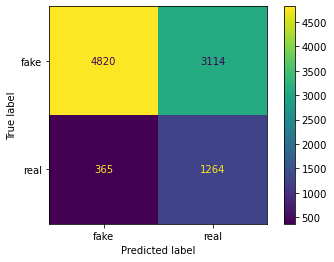

In [23]:
show_metrics(true_labels, model_preds)

In [27]:
model.load_state_dict(torch.load("./DeepSearch_checkpoint")["model_state_dict"])

<All keys matched successfully>

Test loss: 0.5703, Test accuracy: 0.7148
Precision: 0.31687791861240827
Recall: 0.5831798649478207
F1 score: 0.41063323968013826


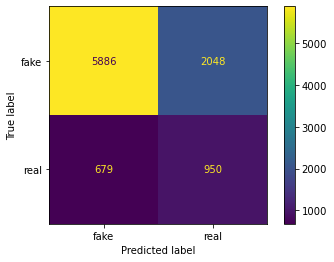

In [28]:
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)
show_metrics(true_labels, model_preds)

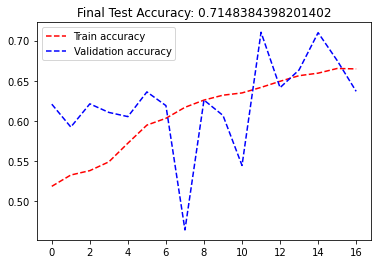

In [29]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

In [74]:
print(train_accuracies)

[0.6762560777957861, 0.678033669681602, 0.6853923772677367, 0.6901631201965808, 0.6929863543681707, 0.6977440267684425, 0.6995216186542583, 0.7055471323260313, 0.7070633136404036, 0.7127489935693, 0.7142521043551001]


In [75]:
print(val_accuracies)

[0.7363797971347903, 0.7485098818362439, 0.7194395064310363, 0.7329289971766182, 0.6680957858412632, 0.7141064519502248, 0.7221583185192931, 0.7283279305657221, 0.6645404161873889, 0.7118059186447767, 0.7450590818780717]


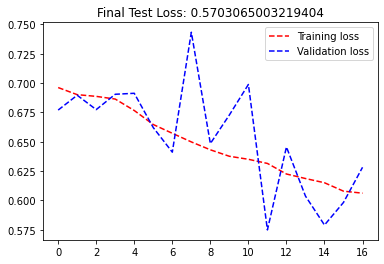

In [30]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

In [76]:
print(train_losses)

[0.5958704539764685, 0.5923885617367799, 0.5841903311751758, 0.582401006417131, 0.5759165241168096, 0.5724374085764422, 0.5678244840141922, 0.562560654304498, 0.562457019768431, 0.5549269104282991, 0.552463824035332]


In [77]:
print(val_losses)

[0.5266908603279215, 0.5174434867344404, 0.5347844158348284, 0.5300105880749854, 0.5958434453136042, 0.5586770208258378, 0.5401998248539472, 0.5440629226596732, 0.5896677319940767, 0.5524137725955561, 0.5016679238331946]


## Old curves, forgot to save values

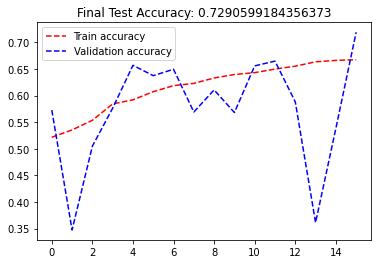

In [88]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

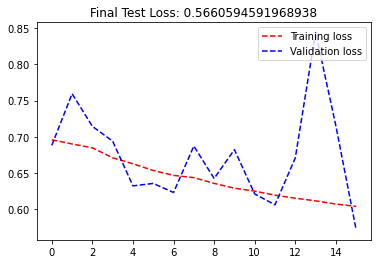

In [89]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [ ]:
test_loader2 = produce_loader(test_data, 1)

In [ ]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

In [ ]:
show_metrics(true_labels2, model_preds2)

In [ ]:
visualize_data(correct_list, (12,12), 5)

In [ ]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

In [26]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './DeepSearch2_13epochs')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])